# Author: 
- Thomas D. Robertson II

# Purpose of this notebook
The purpose of this notebook is to perform EDA, NLP and LDA analysis on the train and test data from the kaggle competition dataset "Natural Language Processing with Disaster Tweets".
Analysis will be done with several different models with the goal of testing the accuracy of the models against one another, with a target F1 score of 0.75 or higher.

# Statement of the Problem:
Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programmatically monitoring Twitter (i.e. disaster relief organizations and news agencies). 

However, identifying whether a tweet is genuinely about a disaster or simply using disaster-related language in another context is not always straightforward. Our project aims to develop a method for distinguishing real disaster-related tweets from those that are unrelated, ensuring more accurate and reliable disaster detection. 


# Dataset Overview:
We are predicting whether a given tweet pertains to  a real disaster or not. In this dataset, a 1 indicates a member of the positive class - a disaster - and a 0 indicates the negative class - no disaster.
- Training Data: 10,000 tweets manually labeled as disaster or not disaster
- Test Data: Unlabeled tweets where the model will predict disaster relevance using NLP.

# Dataset Variables:
- id - a unique identifier for each tweet
- text - the text of the tweet
- location - the location the tweet was sent from (user input, may be blank)
- keyword - a particular keyword from the tweet (may be blank)
- target - denotes whether a tweet indicates a real disaster (1) or not (0). This is intended for model training and validation. The “target” feature is removed in test.csv, the testing data, but has been provided in sample_submission.csv for the purpose of calculating the final testing metrics (F1, accuracy, precision, recall). 

# Success Measures:
Initially, we intend to measure success by comparing the direct results from a selection of  NLP models which will utilize all available training data with minimal filtering. This will be measured by F1, accuracy, precision, recall, and AUC/ROC (area under the curve)

The top models from the initial run will be selected for hypertuning using various methods such as removing unused or confounding variables. Our statistical measurements will include F1 score, area under the curve (AUC and ROC). An F1 score of 0.75 or better is our target goal for our final model. 


# Requirements
The following libraries are required to run this notebook:

# Loading the required libraries

In [27]:
# Handling Warnings
import warnings
warnings.simplefilter(action='ignore', category=Warning)
# Data Analysis Libraries
import pandas as pd
# import numpy as np

# Text  pre-processing
import string, re
# from string import punctuation

# Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# import pyLDAvis
# import pyLDAvis.gensim_models
from wordcloud import WordCloud

# Natural Language Toolkit Libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
# from nltk.stem import PorterStemmer
# from nltk import pos_tag, word_tokenize, ne_chunk
from nltk.stem import WordNetLemmatizer

# Machine Learning
from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
# from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
# from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import cross_validate, cross_val_score, StratifiedKFold, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay


# Converting string data into numerical format with weighings
from sklearn.feature_extraction.text import TfidfVectorizer # used for term frequency and inverse document frequency vectorizer
from sklearn.metrics import classification_report, confusion_matrix
# Pipelining 
from sklearn.pipeline import Pipeline

# Models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# # SpaCY
# import spacy



# Data Loading

In [28]:
# nltk downloads
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('omw-1.4')
# Spacy
# !python -m spacy download en_core_web_md
# nlp = spacy.load("en_core_web_md")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\thoma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\thoma\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\thoma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\thoma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\thoma\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [29]:
# Loading the data into a pandas dataframe
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

# Exploratory Data Analysis
In this section, we will perform exploratory data analysis on the training and testing datasets. We will analyze the distribution of the target variable, the length of tweets, and the most common words used in the tweets. We will also visualize the data using various plots.

In [30]:
# Visualize the rows on training data
train_data.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


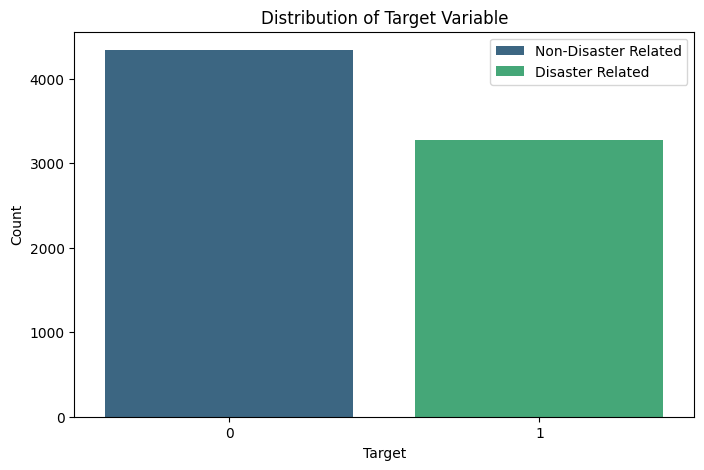

In [31]:
# Show the distribution of target variable
train_data['target'].value_counts()
# Visualize the distribution of target variable
plt.figure(figsize=(8,5))
sns.countplot(x='target', data=train_data, palette=sns.color_palette("viridis", 2))
plt.title('Distribution of Target Variable')
# set legend to 1 is disaster 0 is non-disaster
plt.xlabel('Target')
plt.ylabel('Count')
plt.legend(['Non-Disaster Related', 'Disaster Related'])
plt.show()

In [32]:
# display the target counts
train_data['target'].value_counts()
# Display the percentage of each target class
train_data['target'].value_counts(normalize=True)

target
0    0.57034
1    0.42966
Name: proportion, dtype: float64

We can see a relatively even distribution of the target variable, with a slight imbalance towards the negative class at approximately 57% of the target share. This is important to note as it may affect the performance of our models, but with this rate distribution balancing should not be necessary.

Now we will check the length of tweets to look for any patterns or trends in the tweets related to disaster or normal tweets.

In [33]:
# Checking for the length of tweets via a new column
train_data['length'] = train_data['text'].apply(len)
train_data.head(5)


,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,88


In [34]:
# check the distribution of the len gth of tweets
train_data['length'].describe()

count    7613.000000
mean      101.161697
std        33.854073
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

We can see the average length of tweets in the dataset is 101, the maximum length is 157, and the minimum length is 7.
Lets see if there is anything unusual in higher length tweets.

In [35]:
# Checking the tweets that are greater than 140 characters
pd.set_option('display.max_colwidth', None)
train_data[train_data['length'] > 150]['text'].iloc[:5]


614                             @CAgov If 90BLKs&amp;8WHTs colluded 2 take WHT F @USAgov AUTH Hostage&amp;2 make her look BLK w/Bioterrorism&amp;use her lgl/org IDis ID still hers?@VP
1270                      when you're taking a shower and someone flushes the toilet and you have .1 second to GTFO or you get burned??????????????????????????????????????????????????
4801                           It's was about 2:30 in the morning&amp;I went downstairs to watch some telly&amp;I accidentally made a loud bang&amp;my dad(who has a broken leg)walked-
4929    _\r\n?????RETWEET\r\n???????\r\n?????FOLLOW ALL WHO RT\r\n???????\r\n?????FOLLOWBACK\r\n???????\r\n?????GAIN WITH \r\n???????\r\n?????FOLLOW ?@ganseyman #RT_4_A_MENTION\r\n#TY
Name: text, dtype: object

We Can see from the above tweets that there is a lot of special characters contained within the tweets (such as repeating ?). These characters are arbitrarily increasing the length of the tweets, and will need to be removed in order to get a more accurate representation of the length of the tweets.

Lets visualize the lengths of the words across both targets using a histogram chart in order to see if there are any patterns or trends in the data.

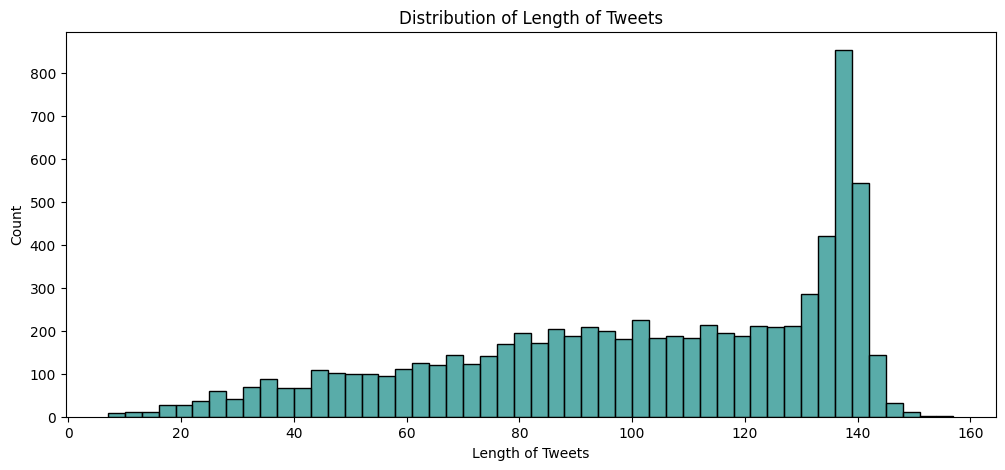

In [36]:
plt.figure(figsize=(12, 5))
sns.histplot(data=train_data, x='length', bins=50, color=sns.color_palette("viridis", as_cmap=True)(0.5))
plt.title('Distribution of Length of Tweets')
plt.xlabel('Length of Tweets')
plt.ylabel('Count')
plt.show()

We can see that the distribution of the length of tweets generally lies in the 70-125 range, with a few outliers on either end. The distribution is slightly skewed to the right, indicating that there are more tweets with shorter lengths than longer ones. Now we will visualize the distribution of the length of tweets for both targets to see if there are any differences between the two classes.

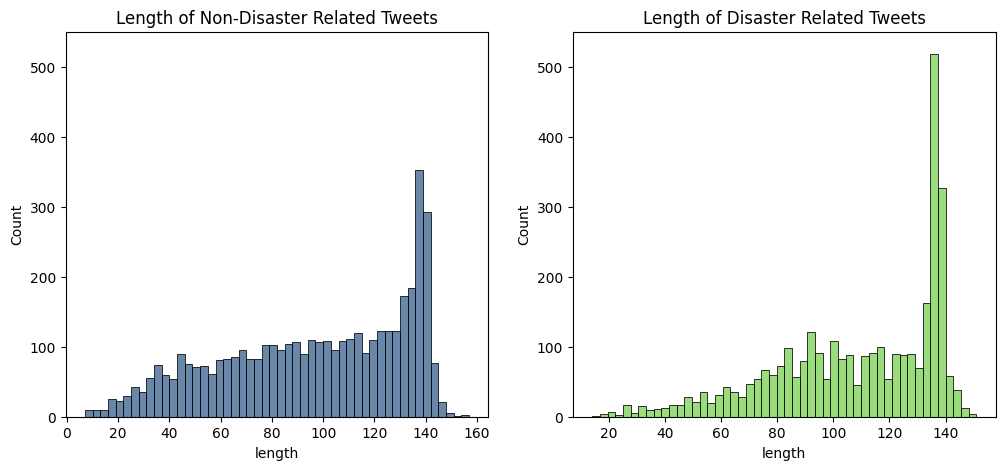

In [37]:
# Visualize the length of tweets of both disaster (target = 1) and non-disaster (target = 0) on two different plots
plt.figure(figsize=(12, 5))
y_limit = 550
plt.subplot(1, 2, 1)
sns.histplot(train_data[train_data['target'] == 0]['length'], bins=50, color=sns.color_palette("viridis", as_cmap=True)(0.3))
plt.ylim(0, y_limit)
plt.title('Length of Non-Disaster Related Tweets')
plt.subplot(1, 2, 2)
sns.histplot(train_data[train_data['target'] == 1]['length'], bins=50, color=sns.color_palette("viridis", as_cmap=True)(0.8))
plt.ylim(0, y_limit)
plt.title('Length of Disaster Related Tweets')

plt.show()

We Can see a signficantly higher distribution of medium length in normal tweets, while disaster related tweets are generally higher length tweets. This is likely due to the nature of disaster related tweets, which are often more detailed and descriptive than normal tweets as they are attempting to give out detailed information regarding the disaster, it's location, causes, etc.

Now we will begin cleaning the data to prepare it for modeling. We will remove any special characters, stop words, and perform stemming and lemmatization on the tweets. We will also remove any duplicates and null values from the dataset. Once the data is cleaned, we will begin by creating a word cloud to visualize the most common words used in the tweets and get a general sense of word distribution.

# Cleaning the Data
Some important steps to clean the data include:
- Removing duplicates
- Removing punctuations, stopwords, and special characters which just add noise to the data
- Removing numerical content from the data which does not apply to the contextual processing.
- Converting all text to lowercase to ensure uniformity
- Removing URLs and links to ensure that the model focuses on the text content
- Removing emojis and other non-textual elements as disaster tweets generally do not contain emojis

In [38]:
# Set stopwords, remove punctuation, and remove links
punctuation = list(string.punctuation)
stop_words = set(stopwords.words('english'))
stop_words.update(punctuation)

def clean_text(text):
    cleaned_text = []
    for word in text.split():
        if word.strip().lower() not in stop_words:
            cleaned_text.append(word.strip())
    return ' '.join(cleaned_text)

# Create new dataframes for target variables (1 = disaster, 0 = non-disaster)
disaster_df = train_data[train_data['target'] == 1]
non_disaster_df = train_data[train_data['target'] == 0]
# remove the stopwords from the new dataframes
disaster_df['text'] = disaster_df['text'].apply(lambda x: clean_text(x))
non_disaster_df['text'] = non_disaster_df['text'].apply(lambda x: clean_text(x))


Now that the data is cleaned, we can begin to visualize the data using a word cloud. A word cloud is a visual representation of the most common words used in a dataset, with the size of each word representing its frequency in the dataset. This will help us to identify any patterns or trends in the data and get a general sense of word distribution.

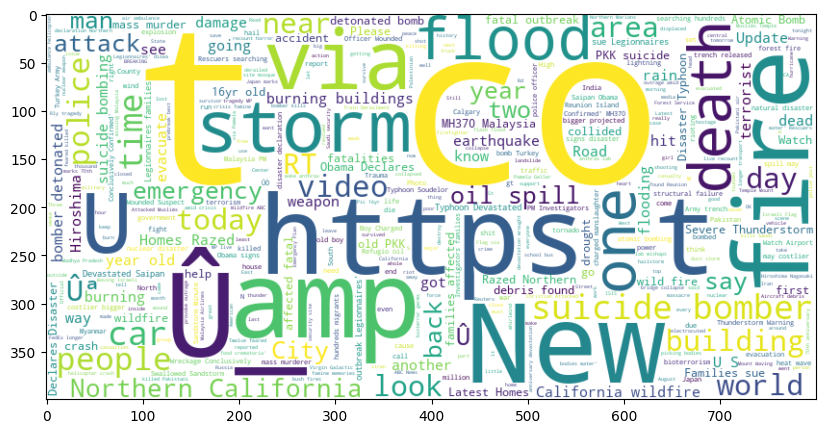

In [39]:
# Create a word cloud visualization for the disaster tweet data
plt.figure(figsize=(12, 5))
word_cloud = WordCloud(max_words = 1000, width=800, height=400, background_color='white', colormap='viridis').generate(' '.join(disaster_df['text']))
plt.imshow(word_cloud, interpolation='bilinear')

We can see in this disaster word cloud that the most common words used in disaster tweets are "fire", "flood", "storm", "suicide bomber", "people", "police", "oil spill", "burning buildings", "California wildfire" and "Northern California". From a first glance at this word_cloud, I would assume a lot of the disaster related tweets are specifically referring to wildfire outbreaks in California.

Now lets plot a word cloud of non-disaster related tweets to see if there is another noticable trend.

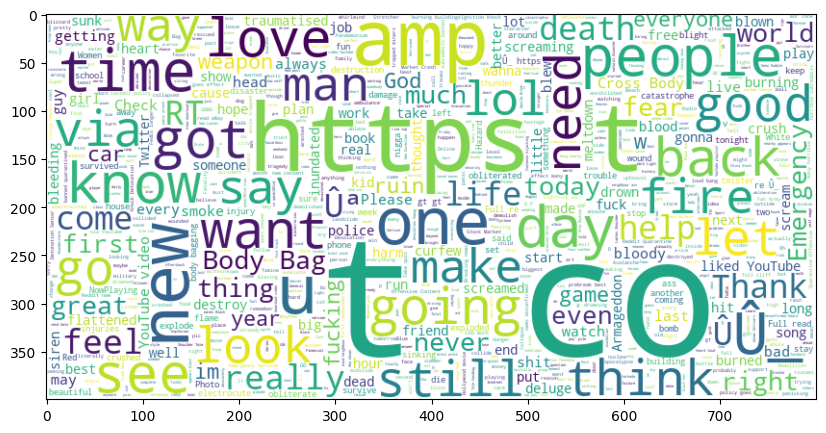

In [40]:
# Create a word cloud visualization for the non-disaster tweet data
plt.figure(figsize=(12, 5))
word_cloud = WordCloud(max_words = 1000, width=800, height=400, background_color='white', colormap='viridis').generate(' '.join(non_disaster_df['text']))
plt.imshow(word_cloud, interpolation='bilinear')

From the non-disaster related tweets we can see thematic patterns such as "love", "people", "help", "Thank", "good", "feel" and "know". We also see some words similar to the disaster cloud such as "fire", and "Emergency". These words are probably being used as general conversation modifiers. One common feature among both set of tweets is the abundance of words such as "https", "CO", and "t". We need to deal with these common noisy words before doing further analysis, so as to keep them from throwing off our models. We will also use porter stemmer on the tweets to account for any regional spelling differences in the tweets.

In [41]:
# porter = nltk.PorterStemmer()
# [porter.stem(t) for t in train_data]
punctuation = list(string.punctuation)
stop_words = set(stopwords.words('english'))
stop_words.update(punctuation)
custom_stop_words = ['amp', 'rt', 'via', 'the', 'a', 'an', 'and', 'is', 'it', 'to', 'in', 'for', 'on', 'of', 'at', 'with', 't', 'co']
stop_words.update(custom_stop_words)

# set the lemmatizer
lemmatizer = WordNetLemmatizer()

def tw_preprocess(tw):
    # convert to lowercase
    tw = tw.lower()
    # Remove mentions (e.g. @username) - includes optional dash
    tw = re.sub(r'@\w+(?:-\w+)*', '', tw)
    # Remove tokens with digits (e.g. alphanumeric strings)
    tw = re.sub(r'\S*\d\S*', '', tw)
    # Remove URLs
    tw = re.sub(r'http\S+', '', tw)
    # Remove hashtags (#) and single quotes/apostrophes
    tw = re.sub(r'[#\']', '', tw)
    
    # Tokenize
    tokens = TweetTokenizer().tokenize(tw)
    # Remove stopwords
    tokens = [t for t in tokens if t not in stop_words]
    # Stem the tokens
    # tokens = [porter.stem(t) for t in tokens]
    # Lemmatize the tokens
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    # Join the tokens back into a string (if desired)
    text = ' '.join(tokens)
    # Remove non-alphabetic characters
    final_text = re.sub('[^a-z]', ' ', text)
    return final_text

## Applying Tweet Processing Function on the Tweets Data
Now we will go ahead and use the tw_preprocess function to prepare, tokenize, and process the tweets for further analysis.

In [42]:
# Drop duplicates
train_data.drop_duplicates(inplace=True)
train_data['cleaned_tweets'] = train_data['text'].apply(tw_preprocess)
train_data.head(5)

,id,keyword,location,text,target,length,cleaned_tweets
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,69,deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,133,resident asked shelter place notified officer evacuation shelter place order expected
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,65,people receive wildfire evacuation order california
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,88,got sent photo ruby alaska smoke wildfire pours school


# Feature Engineering
Now that the data has been cleaned and processed of noise, we can begin creating features (x) and target variables (y) for model analysis. We will use the cleaned tweets as our features and the target variable as our target. We will also split the data into training and testing sets to evaluate the performance of our models.

In [43]:
x = train_data['cleaned_tweets']
y = train_data['target']

In [44]:
# Split the data into training and testing sets with a traditional 80/20 split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## Creation of Bi-grams and Tri-grams with TF-IDF
Now we will create bi-grams and tri-grams from the cleaned tweets using the TF-IDF vectorizer. This will help us to identify any patterns or trends in the data. We will also be ignoring any words that occurs more than 80% of the time in the dataset, as these words are likely to be stop words and will not add any value to our analysis.

In [45]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1, 3))
tfidf_train = tfidf_vectorizer.fit_transform(x_train)
tfidf_test = tfidf_vectorizer.transform(x_test)

# Model Analysis
Now that we have created our features, target variables, and testing/training data, we can begin to analyze the data using various models. We will be using the following models for analysis:
- Naive Bayes (Multinomial)
- Logistic Regression


## Model 1: Naive Bayes
Now we will begin by analyzing the data using the Naive Bayes model. We will be using the Multinomial Naive Bayes model for analysis. We will also be using the following metrics to evaluate the performance of our model:
- F1 Score
- Accuracy
- Precision
- Recall
- AUC/ROC

### Model Fitting

In [46]:
# Pass the vectorized dataframe into the multinomial naive bayes model
mnb = MultinomialNB()
# Fit the model to the training data
mnb.fit(tfidf_train, y_train)
# Pass the vectorized dataframe into the Passive Aggressive Classifier model
pac = PassiveAggressiveClassifier(max_iter=50, random_state=42)
# Fit the model to the training data
pac.fit(tfidf_train, y_train)


PassiveAggressiveClassifier(max_iter=50, random_state=42)

#### Cross Validation

In [47]:
# Perform cross validation for accuracy, precision, recall, and f1 score  using a 10 test fold (with cv - 1 being the training set)
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}
mnb_scores = cross_validate(mnb, tfidf_train, y_train, cv=10, scoring=scoring)
pac_scores = cross_validate(pac, tfidf_train, y_train, cv=10, scoring=scoring)
# Create a DataFrame to store the scores for MultinomialNB
mnb_scores_df = pd.DataFrame({
    'test_accuracy': mnb_scores['test_accuracy'],
    'test_precision': mnb_scores['test_precision'],
    'test_recall': mnb_scores['test_recall'],
    'test_f1': mnb_scores['test_f1']
})

# Cross validate the pac scores
pac_scores_df = pd.DataFrame({
    'test_accuracy': pac_scores['test_accuracy'],
    'test_precision': pac_scores['test_precision'],
    'test_recall': pac_scores['test_recall'],
    'test_f1': pac_scores['test_f1']
})

# Compare the average of the cross-validated scores
crossdict = {
    'MultinomialNB': mnb_scores_df.mean(),
    'PassiveAggressiveClassifier': pac_scores_df.mean()
}
crossdf = pd.DataFrame(crossdict).T
crossdf = crossdf.reset_index()
crossdf = crossdf.rename(columns={'index': 'Model'})
crossdf = crossdf.set_index('Model')
crossdf = crossdf.sort_values(by='test_accuracy', ascending=False)
crossdf


,test_accuracy,test_precision,test_recall,test_f1
Model,,,,
MultinomialNB,0.793924,0.880526,0.603744,0.715922
PassiveAggressiveClassifier,0.793924,0.819141,0.671216,0.736740


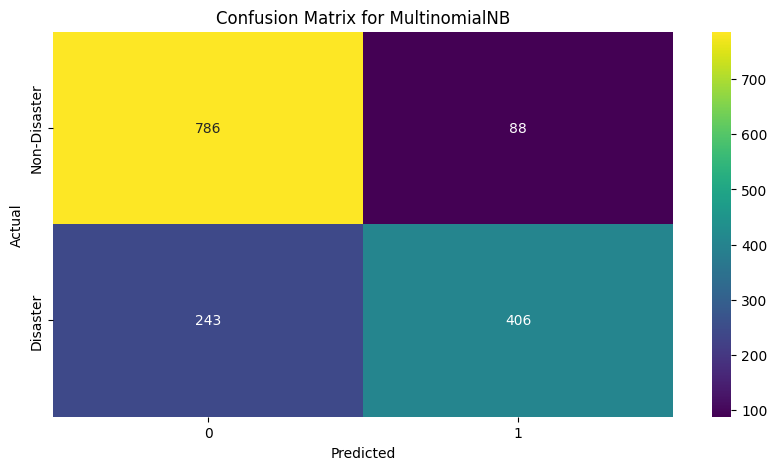

In [48]:
# Display the confusion matrix for the MultinomialNB model
plt.figure(figsize=(10, 5))
mnb_pred = mnb.predict(tfidf_test)
cm_mnb = confusion_matrix(y_test, mnb_pred)
sns.heatmap(cm_mnb, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix for MultinomialNB')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.yticks(ticks=[0.5, 1.5], labels=['Non-Disaster', 'Disaster'])
plt.show()


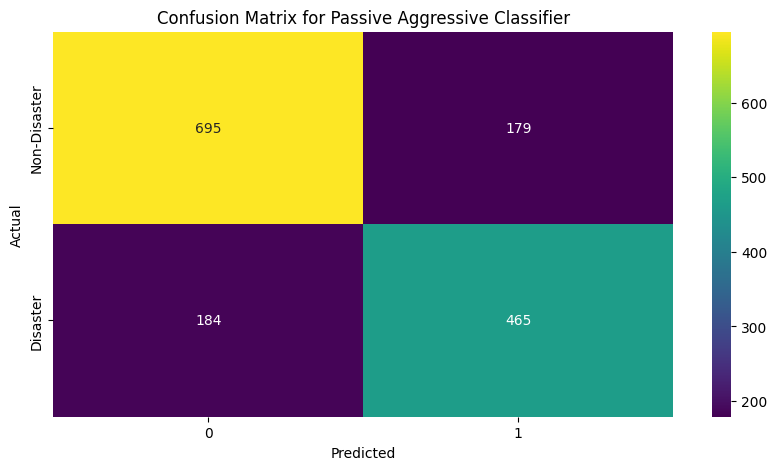

In [49]:
# Display the confusion matrix for the Passive Aggressive Classifier model
plt.figure(figsize=(10, 5))
pac_pred = pac.predict(tfidf_test)
cm_pac = confusion_matrix(y_test, pac_pred)
sns.heatmap(cm_pac, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix for Passive Aggressive Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.yticks(ticks=[0.5, 1.5], labels=['Non-Disaster', 'Disaster'])
plt.show()

# Model Evaluation
Now that we have trained our model, we can begin to evaluate the performance of our model using the metrics we defined earlier. We will also be using the confusion matrix to visualize the performance of our model.

In [50]:
# Evaluate the multinomial naive bayes using the test data
mnb_pred = mnb.predict(tfidf_test)
mnb_acc = accuracy_score(y_test, mnb_pred)
mnb_prec = precision_score(y_test, mnb_pred)
mnb_rec = recall_score(y_test, mnb_pred)
mnb_f1 = f1_score(y_test, mnb_pred)
mnb_roc = roc_auc_score(y_test, mnb.predict_proba(tfidf_test)[:, 1])

# Create a DataFrame to display the results
mnb_test_results = pd.DataFrame({
    'Model': ['Multinomial Naive Bayes'],
    'Accuracy': [mnb_acc],
    'Precision': [mnb_prec],
    'Recall': [mnb_rec],
    'F1 Score': [mnb_f1],
    'ROC AUC': [mnb_roc]
})
mnb_test_results



,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Multinomial Naive Bayes,0.782666,0.821862,0.625578,0.710411,0.848057


In [51]:
# Display the classification report for the MultinomialNB model
print("Classification Report for MultinomialNB:")
print(classification_report(y_test, mnb_pred, target_names=['Non-Disaster', 'Disaster']))

Classification Report for MultinomialNB:
              precision    recall  f1-score   support

Non-Disaster       0.76      0.90      0.83       874
    Disaster       0.82      0.63      0.71       649

    accuracy                           0.78      1523
   macro avg       0.79      0.76      0.77      1523
weighted avg       0.79      0.78      0.78      1523



## Model Analysis - Multinomial Naive Bayes
These results indicate that the classifier is performing reasonably well, achieving an average F1 score of approximately 71.6%. Notably, the model demonstrates high precision—suggesting that it makes few false-positive errors. However, the relatively lower recall indicates that a significant portion of positive cases (i.e., genuine disaster-related tweets) may be missed. This trade-off between precision and recall is a key insight from our current evaluation.

# Model Comparison Pipeline
In this section, we will create a pipeline to compare the performance of different models on the dataset. We will be using the following models for comparison:
- Naive Bayes (Multinomial)
- Logistic Regression
- Random Forest
- Support Vector Machine (SVM)

We will be measuring the performance of each model using the following metrics:
- accuracy
- precision
- recall
- f1
- AUC/ROC





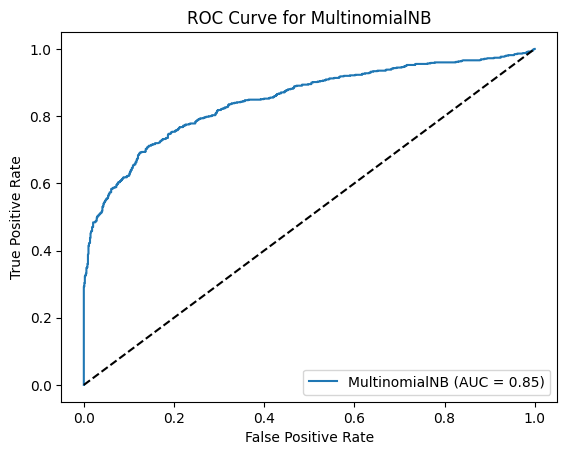

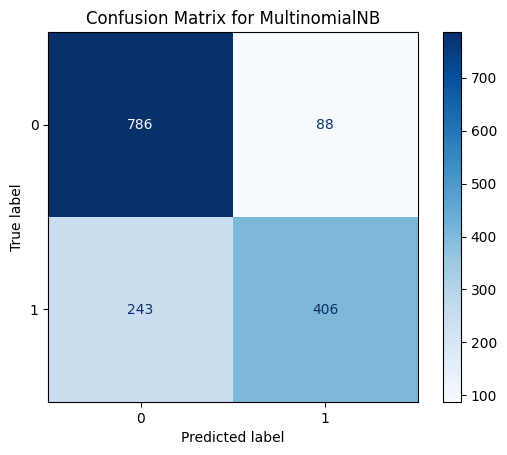

Plotting learning curve for MultinomialNB...


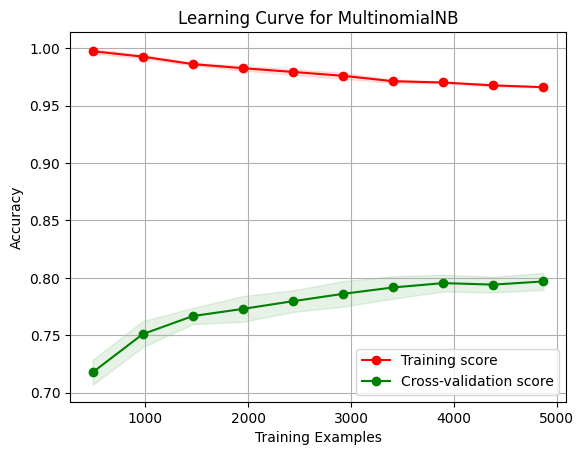

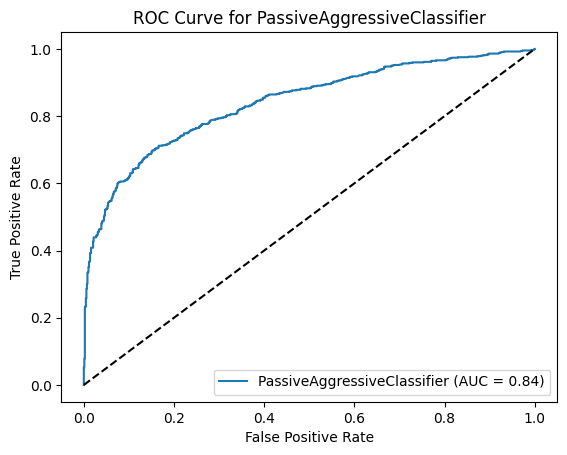

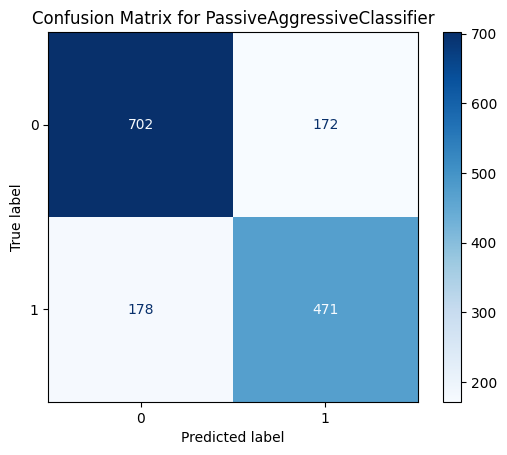

Plotting learning curve for PassiveAggressiveClassifier...


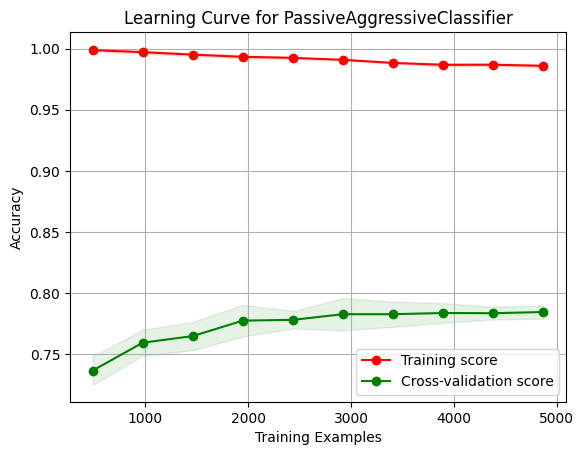

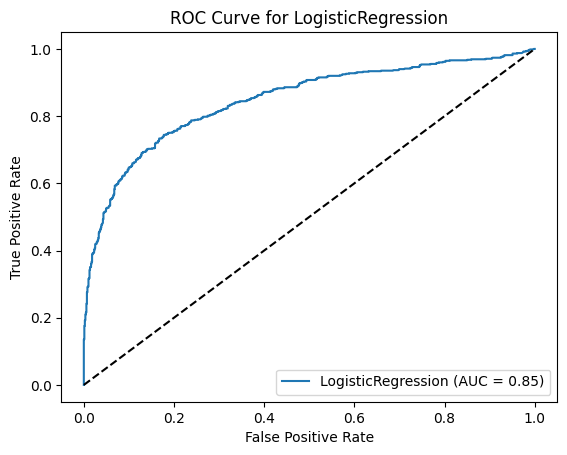

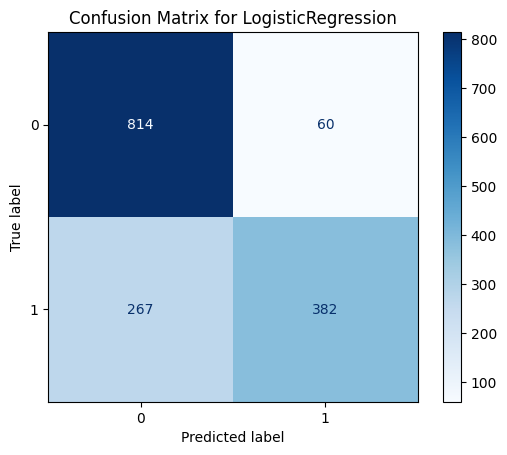

Plotting learning curve for LogisticRegression...


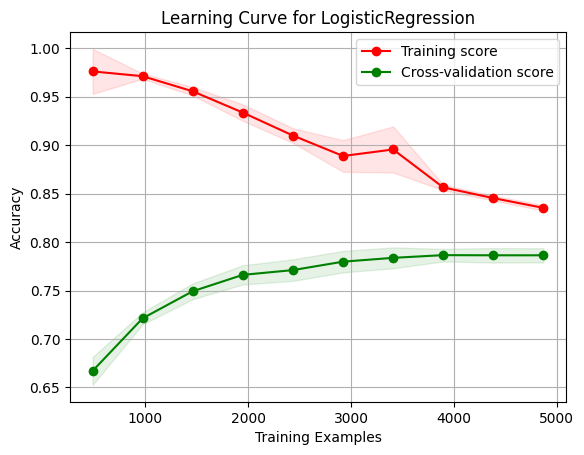

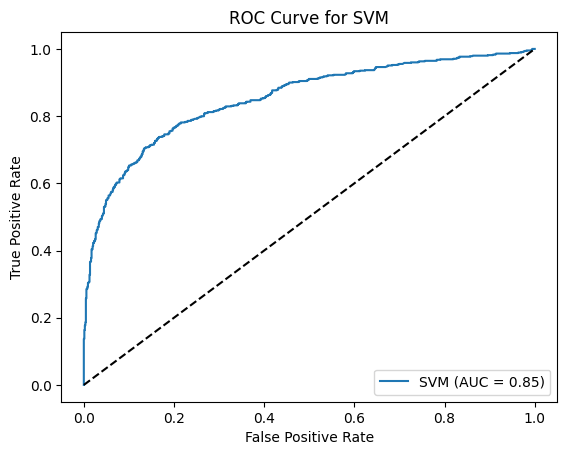

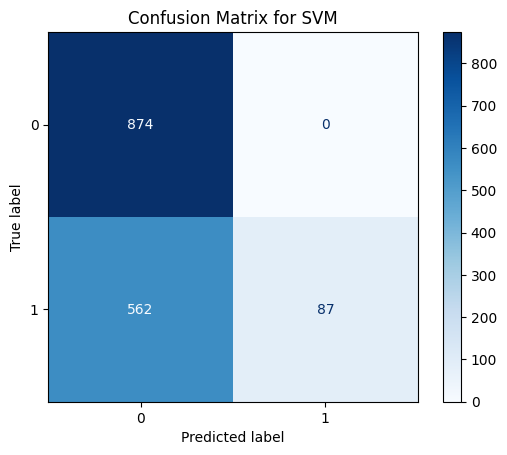

Plotting learning curve for SVM...


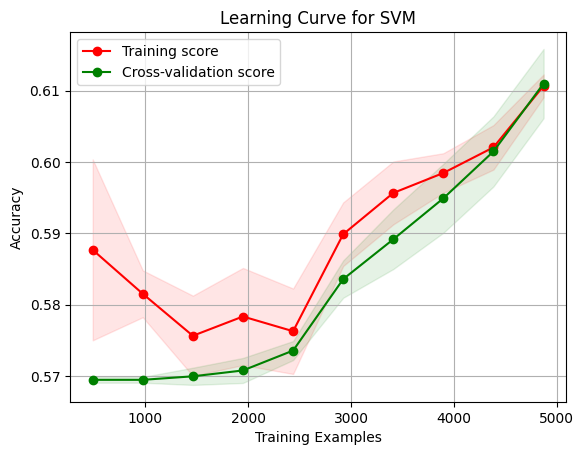

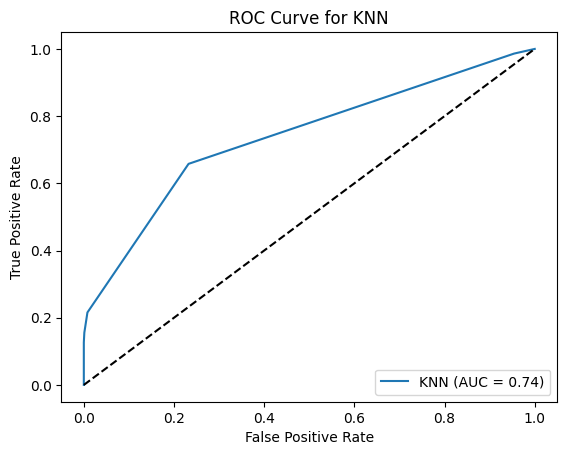

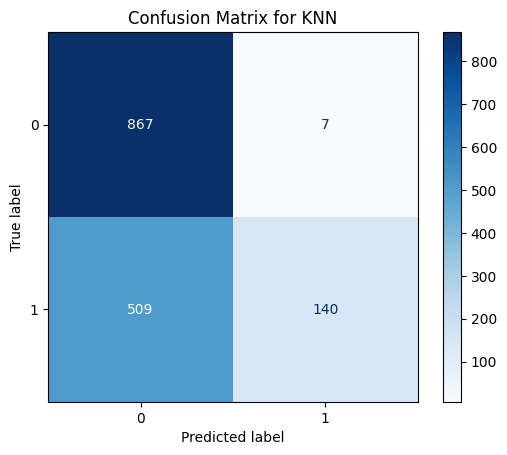

Plotting learning curve for KNN...


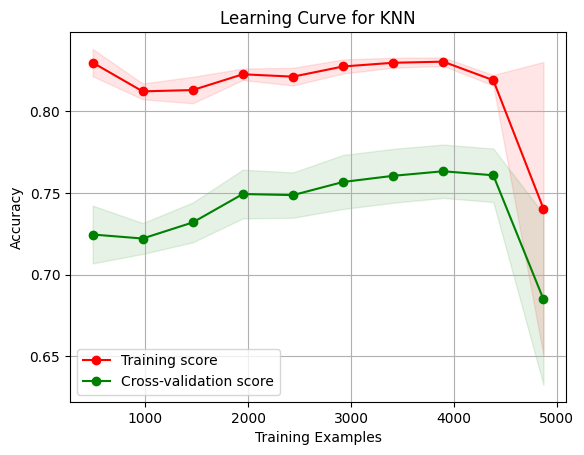

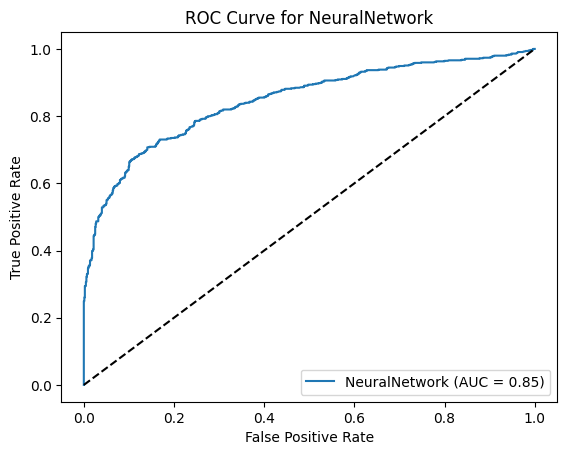

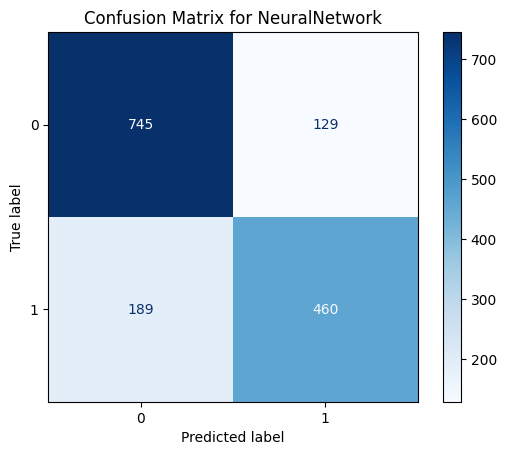

Plotting learning curve for NeuralNetwork...


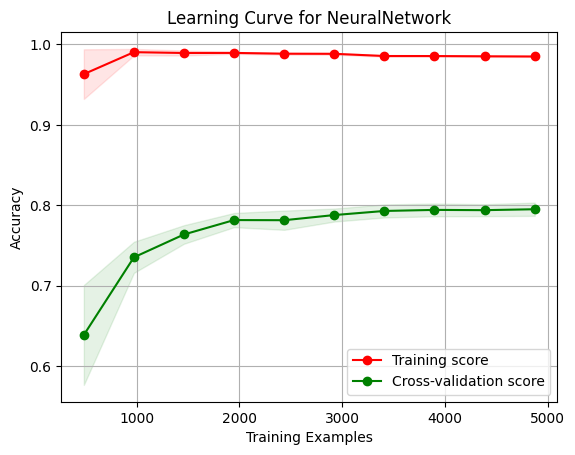

,Accuracy,Precision,Recall,F1 Score,ROC AUC
Model,,,,,
MultinomialNB,0.796880,0.860711,0.630434,0.727641,0.848057
PassiveAggressiveClassifier,0.784565,0.760895,0.728821,0.744287,0.839926
LogisticRegression,0.786371,0.874254,0.588486,0.703394,0.846530
SVM,0.611002,1.000000,0.096482,0.175770,0.852434
KNN,0.684893,0.877513,0.334031,0.445800,0.738328
NeuralNetwork,0.795074,0.790292,0.713577,0.749865,0.846426


In [52]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Function to plot learning curves
def plot_learning_curve(estimator, title, X, y, cv, scoring='accuracy', n_jobs=-1):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=np.linspace(0.1, 1.0, 10)
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure()
    plt.title(title)
    plt.xlabel("Training Examples")
    plt.ylabel(scoring.capitalize())
    
    # Plot the learning curve
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    plt.show()

# Define the pipelines for each model
pipelines = {
    'MultinomialNB': Pipeline([
        ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1, 3))),
        ('clf', MultinomialNB())
    ]),
    'PassiveAggressiveClassifier': Pipeline([
        ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1, 3))),
        ('clf', PassiveAggressiveClassifier(max_iter=5, random_state=42))
    ]),
    'LogisticRegression': Pipeline([
        ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1, 3))),
        ('clf', LogisticRegression(max_iter=5, random_state=42))
    ]),
    'SVM': Pipeline([
        ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1, 3))),
        ('clf', SVC(kernel='linear', C=0.1, probability=True, random_state=42))
    ]),
    'KNN': Pipeline([
        ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1, 3))),
        ('clf', KNeighborsClassifier(n_neighbors=5))
    ]),
    'NeuralNetwork': Pipeline([
        ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1, 3))),
        ('clf', MLPClassifier(hidden_layer_sizes=(50,), batch_size=64, max_iter=5, random_state=42))
    ])
}

# Create a DataFrame to store the results
results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop through the pipelines and calculate the metrics
for model_name, pipeline in pipelines.items():
    # Cross-validated scores
    accuracy = cross_val_score(pipeline, x_train, y_train, cv=cv, scoring='accuracy').mean()
    precision = cross_val_score(pipeline, x_train, y_train, cv=cv, scoring='precision').mean()
    recall = cross_val_score(pipeline, x_train, y_train, cv=cv, scoring='recall').mean()
    f1 = cross_val_score(pipeline, x_train, y_train, cv=cv, scoring='f1').mean()
    
    # Fit the pipeline with the training data to get predictions and ROC AUC
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)
    if model_name == 'PassiveAggressiveClassifier' or model_name == 'SVM':
        y_scores = pipeline.decision_function(x_test)
    else:
        y_scores = pipeline.predict_proba(x_test)[:, 1]
    
    roc_auc = roc_auc_score(y_test, y_scores)
    
    # Create a DataFrame with the current model's results
    model_results = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1 Score': [f1],
        'ROC AUC': [roc_auc]
    })
    
    # Concatenate the current model's results with the overall results
    results = pd.concat([results, model_results], ignore_index=True)
    
    # Plot ROC-AUC curve
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    plt.figure()
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc='lower right')
    plt.show()
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    
    # Plot learning curve
    print(f"Plotting learning curve for {model_name}...")
    plot_learning_curve(pipeline, f"Learning Curve for {model_name}", x_train, y_train, cv=cv)

# Highlight the max value in each column except for 'Model'
results = results.set_index('Model')
results = results.style.highlight_max(axis=0, color='green').set_table_styles(
    [{'selector': 'th', 'props': [('font-size', '14px'), ('color', 'black'), ('background-color', 'white')]}])

# Display the results
results